In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.fftpack import fftfreq
import numpy.fft as fft
from numpy.fft import fft2, ifft2

In [2]:
x_grid = np.linspace(0, 1, 3)
y_grid = np.linspace(0, 1, 50)
dx = x_grid[1] - x_grid[0]
dy = y_grid[1] - y_grid[0]

In [3]:
sin_x = np.cos(2 * np.pi * x_grid)

In [4]:
rho = np.tile(sin_x, (len(y_grid), 1))

In [5]:
(fft.fft2(rho)).shape

(50, 3)

In [6]:
rho = af.to_array(rho)

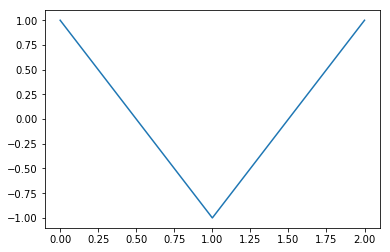

In [7]:
pl.plot(np.array(rho)[0, :])
pl.show()
pl.clf()

In [8]:
def fft_poisson(rho, dx, dy = None):
    """
    FFT solver which returns the value of electric field. This will only work
    when the system being solved for has periodic boundary conditions.

    Parameters:
    -----------
    rho : The 1D/2D density array obtained from calculate_density() is passed to this
          function.

    dx  : Step size in the x-grid

    dy  : Step size in the y-grid.Set to None by default to avoid conflict with the 1D case.

    Output:
    -------
    E_x, E_y : Depending on the dimensionality of the system considered, either both E_x, and
               E_y are returned or E_x is returned.
    """
    if(rho.dims()[1]>2):
        rho_temp = rho[0: -1, 0: -1]

        k_x = af.to_array(fftfreq(rho_temp.dims()[1], dx))
        k_x = af.Array.as_type(k_x, af.Dtype.c64)
        k_y = af.to_array(fftfreq(rho_temp.dims()[0], dy))
        k_x = af.tile(af.reorder(k_x), rho_temp.dims()[0], 1)
        k_y = af.tile(k_y, 1, rho_temp.dims()[1])
        k_y = af.Array.as_type(k_y, af.Dtype.c64)

        rho_hat       = fft2(rho_temp)
        rho_hat = af.to_array(rho_hat)
        potential_hat = af.constant(0, rho_temp.shape[0], rho_temp.shape[1], dtype=af.Dtype.c64)

        potential_hat       = (1/(4 * np.pi**2 * (k_x * k_x + k_y * k_y))) * rho_hat

        potential_hat[0, 0] = 0

        potential_hat = np.array(potential_hat)

        E_x_hat = -1j * 2 * np.pi * np.array(k_x) * potential_hat
        E_y_hat = -1j * 2 * np.pi * np.array(k_y) * potential_hat




        E_x = (ifft2(E_x_hat)).real
        E_y = (ifft2(E_y_hat)).real



        E_x = af.to_array(E_x)
        E_y = af.to_array(E_y)


        E_x = af.join(0, E_x, E_x[0, :])

        E_x = af.join(1, E_x, E_x[:, 0])

        E_y = af.join(0, E_y, E_y[0, :])
        E_y = af.join(1, E_y, E_y[:, 0])   

        E_x[-1, -1] = E_x[0, 0].copy()
        E_y[-1, -1] = E_y[0, 0].copy()

        af.eval(E_x, E_y)


        return(E_x, E_y)
    
    else:
        rho_temp = rho[0: -1, 0: -1]

        k_x = af.to_array(fftfreq(1, dx))
        k_x = af.Array.as_type(k_x, af.Dtype.c64)
        k_y = af.to_array(fftfreq(rho_temp.dims()[0], dy))
        k_x = af.tile(af.reorder(k_x), rho_temp.dims()[0], 1)
        k_y = af.tile(k_y, 1, 1)
        k_y = af.Array.as_type(k_y, af.Dtype.c64)

        rho_hat       = fft2(rho_temp)
        rho_hat = af.to_array(rho_hat)
        potential_hat = af.constant(0, rho_temp.shape[0], 1, dtype=af.Dtype.c64)

        potential_hat       = (1/(4 * np.pi**2 * (k_x * k_x + k_y * k_y))) * rho_hat

        potential_hat[0, 0] = 0

        potential_hat = np.array(potential_hat)

        E_x_hat = -1j * 2 * np.pi * np.array(k_x) * potential_hat
        E_y_hat = -1j * 2 * np.pi * np.array(k_y) * potential_hat




        E_x = (ifft2(E_x_hat)).real
        E_y = (ifft2(E_y_hat)).real



        E_x = af.to_array(E_x)
        E_y = af.to_array(E_y)


        E_x = af.join(0, E_x, E_x[0, :])

        E_x = af.join(1, E_x, E_x[:, 0])

        E_y = af.join(0, E_y, E_y[0, :])
        E_y = af.join(1, E_y, E_y[:, 0])   

        E_x[-1, -1] = E_x[0, 0].copy()
        E_y[-1, -1] = E_y[0, 0].copy()

        af.eval(E_x, E_y)


        return(E_x, E_y)

In [9]:
Ex, Ey = fft_poisson(af.to_array(rho), dx, dy = dy)

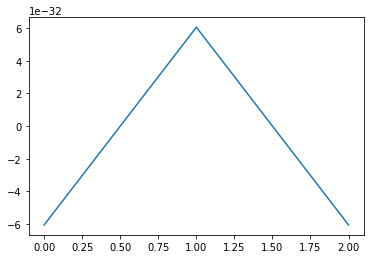

In [10]:
pl.plot(np.array(Ex)[0,:])
pl.show()
pl.clf()

In [11]:
print(af.max(Ex), af.max(Ey))
print(Ex[0, 0], Ex[-1,0], Ex[0,-1], Ex[-1, -1])

1.3501331444404007e-31 1.6531722888277328e-16
arrayfire.Array()
Type: double
[1 1 1 1]
   -0.0000 
 arrayfire.Array()
Type: double
[1 1 1 1]
   -0.0000 
 arrayfire.Array()
Type: double
[1 1 1 1]
   -0.0000 
 arrayfire.Array()
Type: double
[1 1 1 1]
   -0.0000 



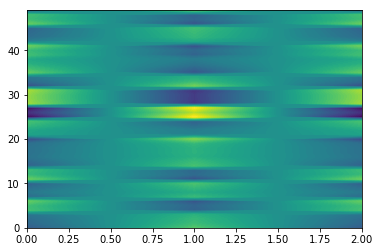

In [12]:
pl.contourf(np.array(Ex), 100)
pl.show()
pl.clf()